1. pdf, word와 같은 문서의 내용을 읽는다.
2. 문서를 쪼갠다(split)
    - 토큰수 초과로 답변을 생성하지 못할 수도 있고
    - 문서가 길면 (input이 길면) 답변 생성이 오래 걸림
        1. chunk_size
        - 나누어진 텍스트 청크(조각)의 최대 문자 수를 지정합니다.
        - 각 청크는 이 크기를 초과하지 않습니다.

        - LLM(Large Language Model)이 처리할 수 있는 입력 크기를 제한하기 위해 사용됩니다.
            - 예를 들어, GPT-3.5의 경우 최대 토큰 수가 4096이므로 적절히 설정해야 합니다.
        2. chunk_overlap
        - 인접한 텍스트 청크 간에 중첩될 문자의 수를 지정합니다.
        - 한 청크의 끝부분 일부가 다음 청크의 시작 부분에 중복됩니다.
        
        - 청크 간의 문맥을 유지하기 위해 사용됩니다. 중첩이 없으면 문장이 잘리거나 의미가 손실될 수 있습니다.
            - 예를 들어, 문장이 한 청크의 끝에서 잘리고 다음 청크의 시작에 포함되지 않으면, 모델이 문맥을 올바르게 이해하지 못할 수 있습니다.
3. 임베딩(데이터를 숫자 형태의 벡터 형식으로 변환) -> 벡터 데이터베이스에 저장
4. 질문이 있을 때, 벡터 데이터베이스에 유사도 검색
5. 유사도 검색으로 가져온 문서를 LLM에 질문과 같이 전달

- Retrieval 효율성을 위해서는 이미지보다는 텍스트로 정리된 문서가 필요
- 이미지를 표로 생성
    - 그렇다고 일반 표 형식이 아닌 마크다운의 표 형식으로 작성되어야함
    
    ex)
    
    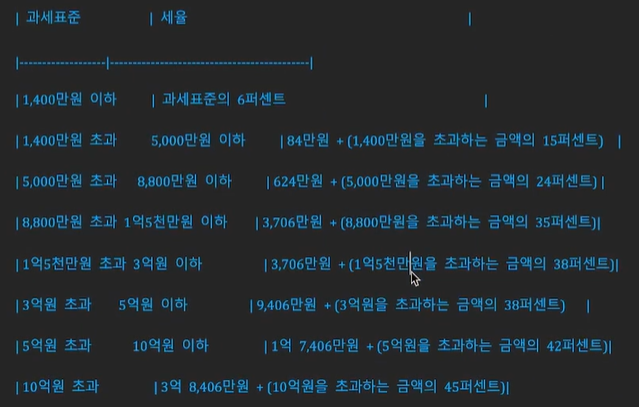

- Retrieval 유사도 검색 시 예를 들어 직장인의 소득세, 거주자의 소득세는 거리가 먼 키워드로 인식되어 유사도가 낮아 우선순위가 낮게 나올 수 있음
- | <- 이 텍스트는 OR 가 아닌 Langchain Expression Language 로 인식된다.
    - pipe로서 왼쪽에서 오른쪽으로 넘겨준다는 의미



In [1]:
%pip install -qU langchain_community pypdf

Note: you may need to restart the kernel to use updated packages.


In [2]:
%cp /mnt/c/Users/suholee/Downloads/split/split-1.pdf /root/llm-application/


In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 텍스트 스플릿 (몇개씩 자를 것인지)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
)

loader = PyPDFLoader(
    "./split-1.pdf",
)
document_list = loader.load_and_split(text_splitter=text_splitter)

In [4]:
document_list

[Document(metadata={'source': './split-1.pdf', 'page': 0, 'page_label': '1'}, page_content='Spring Boot Reference Documentation\nPhillip Webb, Dave Syer, Josh Long, Stéphane Nicoll, Rob Winch, Andy\nWilkinson, Marcel Overdijk, Christian Dupuis, Sébastien Deleuze, Michael\nSimons, Vedran Pavić, Jay Bryant, Madhura Bhave, Eddú Meléndez, Scott\nFrederick, Moritz Halbritter\nVersion 3.2.7'),
 Document(metadata={'source': './split-1.pdf', 'page': 1, 'page_label': '2'}, page_content='Table of Contents\n1. Legal . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . \xa02\n2. Getting Help . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . \xa03\n3. Documentation Overview . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [5]:
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings

load_dotenv()

embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [6]:
import os
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

index_name = 'spring-index'
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)

database = PineconeVectorStore.from_documents(document_list, embedding, index_name=index_name)

/root/.pyenv/versions/llm-application/lib/python3.10/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [14]:
query = '파이썬과 C와 같은 언어와 함께 사용되는 프레임워크는 무엇이 있나요'
retrieved_docs = database.similarity_search(query, k = 3)


In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')


In [9]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

/root/.pyenv/versions/llm-application/lib/python3.10/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
from langchain.chains import RetrievalQA

retriever = database.as_retriever()  # VectorStore에서 retriever 생성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt}  # 필요한 경우 추가 인자 설정
)
ai_message = qa_chain({"query": query})
ai_message

/tmp/ipykernel_1383/285634311.py:9: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  ai_message = qa_chain({"query": query})


{'query': '참고한 텍스트에서 ssl은 번호가 몇번 인가요? 그리고 첫 문장을 그대로 작성해봐주세요. 문장은 영어여도 상관없어요. 하지만 답변은 한글이어야 해요',
 'result': 'SSL은 번호 7.14입니다. 첫 문장은 "Spring Boot provides the ability to configure SSL trust material that can be applied to several types of connections in order to support secure communications."입니다.'}

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

dictionary = ["언어를 나타내는 표현 -> 자바 혹은 코틀린"]

prompt = ChatPromptTemplate.from_template(
f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
만약 변경할 필요가 없다고 판단된다면, 사용자의 질문을 변경하지 않아도 됩니다.
사전: {dictionary}

질문: {{question}}

""")

chain = prompt | llm | StrOutputParser()

In [16]:
new_question = chain.invoke({"question": query})
new_question

'질문: 파이썬과 C와 같은 언어와 함께 사용되는 스프링은 무엇이 있나요'

In [18]:
spring_chain = {"query": chain} | qa_chain

In [19]:
ai_response = spring_chain.invoke({"question": query})
ai_response

{'query': '파이썬과 C와 같은 언어와 함께 사용되는 스프링은 무엇이 있나요?',
 'result': '파이썬과 C와 같은 언어와 함께 사용되는 스프링 템플릿 엔진으로는 FreeMarker, Groovy, Thymeleaf, 그리고 Mustache가 있습니다. JSP는 사용을 피하는 것이 좋습니다.'}